# Analysis of LLM re-ranking results

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stylia
from stylia.colors.colors import NamedColors

df = pd.read_csv("../results/results_pairs/chemical_gene_pairs_prediction_output_focus_with_variant_aggregates_top50_filter_llm_top10.csv")

chemicals = list(df["chemical"].unique())
cap2name = dict((c.capitalize(), c) for c in chemicals)
chemicals = sorted([c.capitalize() for c in chemicals])

drug_renames = {
    "P-aminosalicylic acid": "Aminosalicylic acid",
    "Linezolide": "Linezolid"
}

def rename_old_to_new(drug):
    drug_o_n = dict((k, v) for k, v in drug_renames.items())
    if drug in drug_o_n:
        return drug_o_n[drug]
    return drug

def rename_new_to_old(drug):
    drug_n_o = dict((v, k) for k, v in drug_renames.items())
    if drug in drug_n_o:
        return drug_n_o[drug]
    return drug

chemicals = sorted([rename_old_to_new(c) for c in chemicals])
chemicals = [rename_new_to_old(c) for c in chemicals]

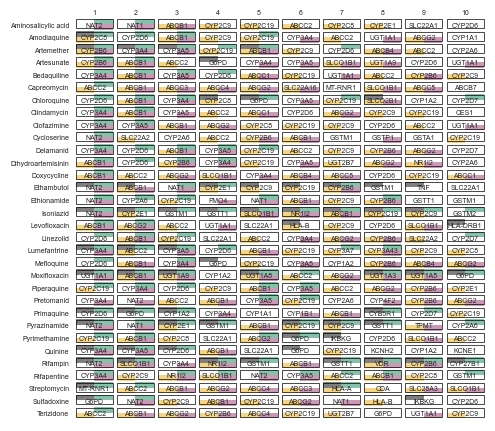

In [73]:
named_colors = NamedColors()
black = named_colors.black
green = named_colors.green
yellow = named_colors.yellow
purple = named_colors.purple
white = "white"

fig, axs = stylia.create_figure(1, 1, width=stylia.TWO_COLUMNS_WIDTH*0.7, height=stylia.TWO_COLUMNS_WIDTH*0.6)
ax = axs.next()
ax.set_ylim(len(chemicals), -1)

colors = [named_colors.black, named_colors.green, named_colors.yellow, named_colors.purple]

OFFSET = 0.45

def little_square(ax, i, j, quadrant, color):
    i = i - 0.5
    offset = OFFSET
    if quadrant == 0:
        offset_x = -offset
        offset_y = 0
    if quadrant == 1:
        offset_x = 0
        offset_y = 0
    if quadrant == 2:
        offset_x = -offset
        offset_y = offset
    if quadrant == 3:
        offset_x = 0
        offset_y = offset
    x = j + offset_x
    y = i + offset_y
    ax.add_patch(plt.Rectangle((x, y), offset, offset, facecolor=color, edgecolor="none", alpha=0.5, linewidth=0))

def frame(ax, i, j):
    i = i - OFFSET
    j = j - OFFSET
    ax.add_patch(plt.Rectangle((j, i), OFFSET*2, OFFSET*2*0.9, facecolor="none", edgecolor="black", linewidth=0.5))

for i in range(len(chemicals)):
    ax.text(0.4, i, rename_old_to_new(chemicals[i]), ha="right", va="center")
    df_ = df[df["chemical"] == cap2name[chemicals[i]]].sort_values(by="llm_rank", ascending=True).head(10)
    genes = list(df_["gene"])
    in_pgkb = []
    for x in df_[['train_set', 'train_set_pk', 'train_set_pk_adme']].sum(axis=1).tolist():
        if x == 0:
            in_pgkb += [0]
        else:
            in_pgkb += [1]
    zscores = np.clip(list(df_["consensus_zscore"]), 0, 5)
    afr_a = df_["afr_abundant_variants"].tolist()
    afr_s = df_["afr_specific_variants"].tolist()
    for j, g in enumerate(genes):
        if in_pgkb[j] == 1:
            little_square(ax, i, j+1, 0, black)
        else:
            little_square(ax, i, j+1, 0, white)
        if zscores[j] > 1.95:
            little_square(ax, i, j+1, 1, green)
        else:
            little_square(ax, i, j+1, 1, white)
        if afr_a[j] >= 50:
            little_square(ax, i, j+1, 2, yellow)
        else:
            little_square(ax, i, j+1, 2, white)
        if afr_s[j] > 0:
            little_square(ax, i, j+1, 3, purple)
        else:
            little_square(ax, i, j+1, 3, white)
        ax.text(j+1, i, g, ha="center", va="center")
        frame(ax, i, j+1)

for i in range(10):
    ax.text(i+1, -1, str(i+1), ha="center", va="center")

ax.set_ylim(len(chemicals)-0.4, -0.5)
ax.set_xlim(-0.5, 10.5)
ax.set_axis_off()
stylia.label(ax, title="", xlabel="", ylabel="")

plt.tight_layout()
plt.savefig("assets/top10_genes_per_chemical.png", dpi=300)

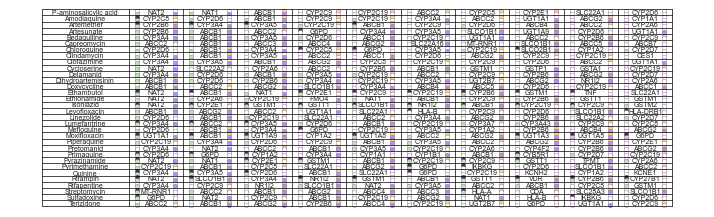

In [20]:
fig, axs = stylia.create_figure(1, 1, width=stylia.TWO_COLUMNS_WIDTH, height=stylia.TWO_COLUMNS_WIDTH*0.3)
ax = axs.next()

green = "#BEE6B4"
orange = "#FAA08C"
yellow = "#FAD782"
plum = "#50285A"
gray = "#D2D2D0"
purple = "#AA96FA"

for i in range(len(chemicals)):
    ax.text(-0.3, i, chemicals[i], ha="center", va="center")
    df_ = df[df["chemical"] == cap2name[chemicals[i]]].sort_values(by="llm_rank", ascending=True).head(10)
    genes = list(df_["gene"])
    in_pgkb = []
    for x in df_[['train_set', 'train_set_pk', 'train_set_pk_adme']].sum(axis=1).tolist():
        if x == 0:
            in_pgkb += [0]
        else:
            in_pgkb += [1]
    zscores = np.clip(list(df_["consensus_zscore"]), 0, 5)
    afr_a = df_["afr_abundant_variants"].tolist()
    afr_s = df_["afr_specific_variants"].tolist()
    for j, g in enumerate(genes):
        if in_pgkb[j] == 1:
            ax.scatter(j+0.65, i-0.2, color=plum, edgecolor=plum, linewidth=0.2)
        else:
            ax.scatter(j+0.65, i-0.2, color="white", edgecolor=plum, linewidth=0.2)
        if zscores[j] > 1.95:
            ax.scatter(j+0.65, i+0.2, color=green, edgecolor=plum, linewidth=0.2)
        else:
            ax.scatter(j+0.65, i+0.2, color="white", edgecolor=plum, linewidth=0.2)
        if afr_a[j] >= 50:
            ax.scatter(j+1.35, i-0.2, color=yellow, edgecolor=plum, linewidth=0.2)
        else:
            ax.scatter(j+1.35, i-0.2, color="white", edgecolor=plum, linewidth=0.2)
        if afr_s[j] > 0:
            ax.scatter(j+1.35, i+0.2, color=purple, edgecolor=plum, linewidth=0.2)
        else:
            ax.scatter(j+1.35, i+0.2, color="white", edgecolor=plum, linewidth=0.2)
        ax.text(j+1, i, g, ha="center", va="center")
        
for i in range(len(chemicals)+1):
    ax.plot([-1.1, len(genes)+0.5], [i-0.5, i-0.5], color="black", linewidth=0.5)

for j in range(len(genes)+1):
    ax.plot([j+0.5, j+0.5], [-0.5, len(chemicals)-0.5], color="black", linewidth=0.5)

ax.plot([-1.1, -1.1], [-0.5, len(chemicals)-0.5], color="black", linewidth=0.5)

ax.set_ylim(len(chemicals)-0.4, -0.5)
ax.set_axis_off()
stylia.label(ax, title="", xlabel="", ylabel="")

plt.tight_layout()

stylia.save_figure("assets/top10_genes_per_chemical.png")